In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "../source"
sys.path.append(source)

from preprocessing import Direct
from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import models

device = torch.device("cpu")

plot_path = "plots/XOR/"
save = True

In [2]:
## Load settings
setting = "rich"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/XOR.txt", sep=" ", header=0).loc[setting].to_numpy()
)
model_type = getattr(models, model_type)

if nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [3]:
## Generate data
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([[0], [1], [1], [0]])

outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)
inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)

input_labels = [(int(x[0].item()), int(x[1].item())) for x in inputs]

encoding = Direct()

dataset = TensorDataset(inputs, outputs)
train_datasets = [dataset]
val_dataset = [dataset]

tracked_datasets = val_dataset + train_datasets

In [4]:
## Load fitted effective learing rates
etas_h = np.load("./plots/2_points/comparisons/etas_h.pkl", allow_pickle=True)
etas_y = np.load("./plots/2_points/comparisons/etas_y.pkl", allow_pickle=True)
eta_h = np.mean(etas_h["default"])
eta_y = np.mean(etas_y["default"])

# Run rich_structure.ipynb first!
# This script uses the effective learning rates computed there

FileNotFoundError: [Errno 2] No such file or directory: './plots/2_points/comparisons/etas_h.pkl'

In [5]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=torch.nn.functional.relu,
)

In [6]:
## Plot theory
h_0 = [model(input)[1][hidden_layer].detach().numpy() for input in inputs]
y_0 = [model(input)[0].detach().numpy() for input in inputs]

dist_x = scipy.spatial.distance_matrix(inputs, inputs)
dist_y = scipy.spatial.distance_matrix(outputs, outputs)
dist_h_0 = scipy.spatial.distance_matrix(h_0, h_0)
dist_y_0 = scipy.spatial.distance_matrix(y_0, y_0)

A_low = np.sqrt(eta_h / eta_y) * dist_y * dist_x
A_high = (
    (dist_h_0 / dist_x) ** 2 - (dist_y_0 / dist_h_0) ** 2 * eta_h / eta_y
) * dist_x**2
h_final = np.sqrt(0.5 * (A_high + np.sqrt(A_high**2 + 4 * A_low**2)))
np.fill_diagonal(h_final, 0)

publication.set_color_gradient(index=2)
figsize = 2.5 * np.array([1, 1])
fig = plt.figure(figsize=figsize)

plt.imshow(h_final)
if save:
    publication.im_show(
        x_labels=input_labels,
        y_labels=input_labels,
        save_path=plot_path + setting + "_theory",
    )
else:
    publication.im_show(x_labels=input_labels, y_labels=input_labels)

NameError: name 'eta_h' is not defined

In [ ]:
## Setup compiler
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][hidden_layer],
        datasets=val_dataset,
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=val_dataset
    ),
}

In [ ]:
## Training run
compiler.training_run(train_datasets, n_epochs=n_epochs, batch_size=100)

Training: 100%|██████████| 1000/1000 [00:29<00:00, 34.12steps/s, train_loss=0.00000, val_loss=0.00000]


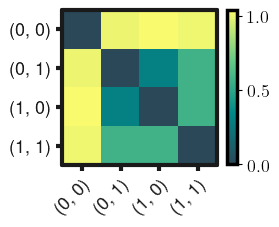

In [ ]:
## Plot experiment
publication.set_color_gradient(index=2)
figsize = np.array([2.5, 2.5])

fig = plt.figure(figsize=figsize)

data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
final_epoch = data_hid.index.get_level_values("Epoch")[-1]
h = data_hid.query(f"Epoch=={final_epoch}")
dist_h = scipy.spatial.distance_matrix(h, h)

plt.imshow(dist_h)

if save:
    publication.im_show(
        x_labels=input_labels, y_labels=input_labels, save_path=plot_path + setting
    )
else:
    publication.im_show(x_labels=input_labels, y_labels=input_labels)